In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import pandas as pd
import sys
import re
import os
import math

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


from sklearn import preprocessing
import sklearn

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
XXtrain = np.loadtxt(open("/users/shaoketong/box sync/Experimental Data/data_24Sep/XXtrain.csv","rb"), delimiter=",", skiprows=0)
YYtrain = np.loadtxt(open("/users/shaoketong/box sync/Experimental Data/data_24Sep/YYtrain.csv","rb"), delimiter=",", skiprows=0).reshape(-1,1)


In [6]:
################################################################################
# CHECK DIMENSIONS AND STRUCTURE OF THE DATA
################################################################################
print('XXtrain dimensions = ', XXtrain.shape)
print('YYtrain dimensions = ', YYtrain.shape)

# Find where He concentration is changed to determine how many steps and how many points per step we have
Heidx = np.where(np.diff(YYtrain.reshape(-1,))!=0)
Heidx = Heidx[0]+1
Npoints = len(YYtrain[Heidx[0]:Heidx[1],0]) # Number of points per He concentration step
Nchanges = ((len(YYtrain)-1)/Npoints)       # Number of He concentration steps



print(Npoints)

XXtrain dimensions =  (2881, 2048)
YYtrain dimensions =  (2881, 1)
40


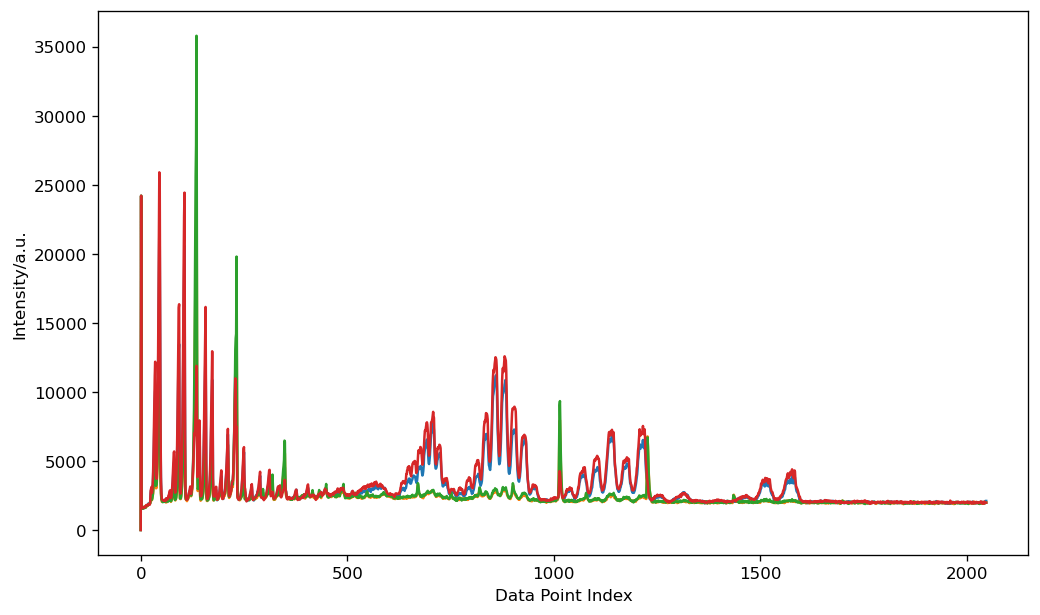

In [7]:
# Plot the first 10 spectra on the same plot to motivate taking averages
plt.figure(dpi=120)
for i in range(4):
    plt.plot(XXtrain[i, :])
# plt.legend(['0', '1', '2', '3'])
plt.xlabel('Data Point Index')
plt.ylabel('Intensity/a.u.')
plt.show()

Xtrain_split dimensions =  (50, 2048)    Ytrain_split dimensions =  (50, 1)
Xtest_split dimensions  =  (22, 2048)    Ytest_split  dimensions =  (22, 1)


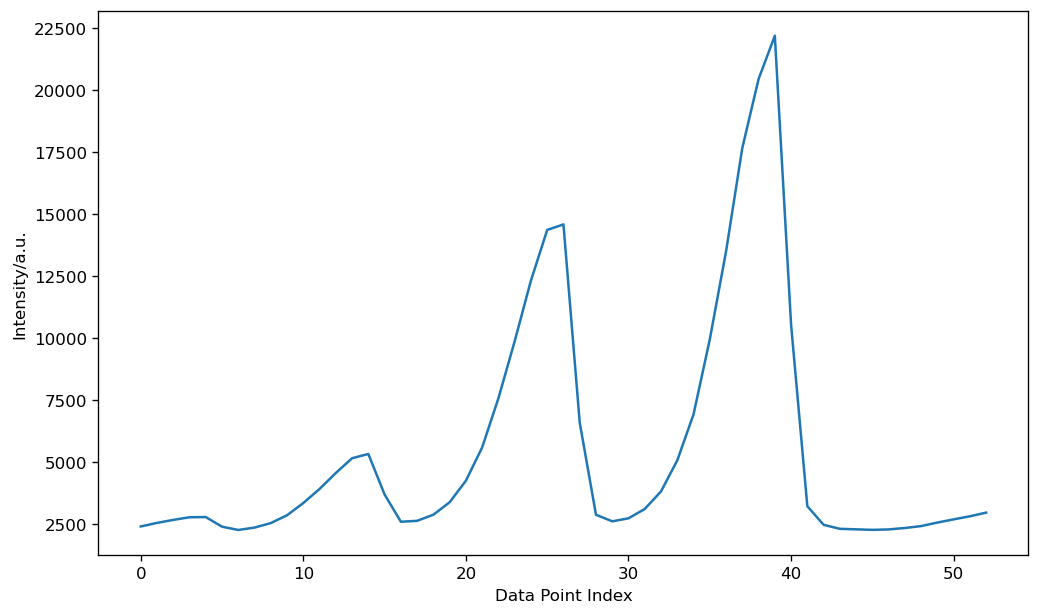

(72, 199) (72, 1)


In [8]:
################################################################################
# SPLIT INTO TRAINING AND TEST DATASETS
################################################################################

# Split training and test datasets while maintaining the time sequence (do not shuffle)
# Approximately 80% for training and 20% for testing/validation
trainFrac = 0.7
trainIdx = []
testIdx = []
for j in range(1, int(round(Nchanges*trainFrac)*Npoints), Npoints):
    trainIdx += [list(range(j, j+Npoints))] 

for j in range(int(round(Nchanges*trainFrac)*Npoints)+1, len(YYtrain)-1, Npoints):
    testIdx += [list(range(j, j+Npoints))]

# Xtest = XXtrain[testIdx,:]
# Ytest = YYtrain[testIdx, 0]

# Average portions of the OES
Xtrain_split = np.zeros((len(trainIdx), XXtrain.shape[1]))
Ytrain = np.zeros((len(trainIdx), 1))

for j in range(0,len(trainIdx)):
    Xtrain_split[j,:] = np.average(XXtrain[trainIdx[j],:], axis=0)
    Ytrain[j,0] = np.average(YYtrain[trainIdx[j], 0])

Xtest_split = np.zeros((len(testIdx), XXtrain.shape[1]))
Ytest = np.zeros((len(testIdx), 1))
for j in range(0,len(testIdx)):
    Xtest_split[j,:] = np.average(XXtrain[testIdx[j],:], axis=0)
    Ytest[j,0] = np.average(YYtrain[testIdx[j], 0])

print('Xtrain_split dimensions = ', Xtrain_split.shape, '   Ytrain_split dimensions = ', Ytrain.shape)
print('Xtest_split dimensions  = ', Xtest_split.shape,  '   Ytest_split  dimensions = ', Ytest.shape)

# Normalize results so that they range from 0 to 1 (better for ML training)
#Ytrain = (1-Ytrain)/float(max(1-Ytrain))
#Ytest = (1-Ytest)/float(max(1-Ytest))

plt.figure(dpi=120)
plt.plot(Xtrain_split[1, 67:120])
# plt.legend(['0', '1', '2', '3'])
plt.xlabel('Data Point Index')
plt.ylabel('Intensity/a.u.')
plt.show()


index = list(range(0,len(Xtrain_split)+len(Xtest_split)))
np.random.seed(42)
np.random.shuffle(index) 
Yoriginun = np.vstack([Ytrain,Ytest])[index]
Xoriginun = np.vstack([Xtrain_split[:, 1:200],Xtest_split[:, 1:200]])[index,:]

print(Xoriginun.shape,Yoriginun.shape)

# PCA
Please fit the PCA first on the training data then apply to the test data.
Otherwise, you might face the risk of information leakage.

In [14]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler = preprocessing.MinMaxScaler().fit(Xtrain_split)
scaled_Xtrain = scaler.transform(Xtrain_split)
scaled_Xtest = scaler.transform(Xtest_split)

pca = PCA(n_components=50).fit(scaled_Xtrain)
# Note: you have to reduce the dimension to a number between 0 and min(n_samples, n_features)
# otherwise, it will rise an error, this is caused by the mathematical basis of PCA
PCA_Xtrain = pca.transform(scaled_Xtrain)
PCA_Xtest = pca.transform(scaled_Xtest)

Xtrain = np.zeros((Xtrain_split.shape[0],Xtrain_split.shape[1]))
Xtest = np.zeros((Xtest_split.shape[0],Xtest_split.shape[1]))
Xtrain = PCA_Xtrain
Xtest = PCA_Xtest


print('Xtrain dimensions = ', Xtrain.shape, '   Ytrain dimensions = ', Ytrain.shape)
print('Xtest dimensions  = ', Xtest.shape,  '   Ytest  dimensions = ', Ytest.shape)


Xtrain dimensions =  (50, 50)    Ytrain dimensions =  (50, 1)
Xtest dimensions  =  (22, 50)    Ytest  dimensions =  (22, 1)


In [12]:
# use this build-in method to directly how much information we can get if we add one more dimension.
# Here, the dimension can be reduced to 5 while maintaining the most information
pca.explained_variance_ratio_

array([6.29919714e-01, 3.65990272e-02, 2.38606982e-02, 2.22882028e-02,
       1.59595300e-02, 9.03438008e-03, 8.83279718e-03, 8.37652028e-03,
       8.32486955e-03, 8.30615894e-03, 8.11408221e-03, 7.88846100e-03,
       7.86060236e-03, 7.59468256e-03, 7.45526059e-03, 7.40456855e-03,
       7.25202988e-03, 7.09993609e-03, 6.95038338e-03, 6.84037805e-03,
       6.66212792e-03, 6.60366505e-03, 6.46433962e-03, 6.40951833e-03,
       6.34009397e-03, 6.29210139e-03, 6.06476150e-03, 6.04014431e-03,
       5.98200593e-03, 5.84612250e-03, 5.77814408e-03, 5.64589817e-03,
       5.52059394e-03, 5.45304754e-03, 5.27837868e-03, 5.24689129e-03,
       5.14789351e-03, 5.03069519e-03, 4.92086265e-03, 4.75253427e-03,
       4.68025045e-03, 4.65011036e-03, 4.56068744e-03, 4.42108689e-03,
       4.40662426e-03, 4.33851109e-03, 4.16642210e-03, 3.76729795e-03,
       3.56690671e-03, 1.07855452e-31])

In [15]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler = preprocessing.MinMaxScaler().fit(Xtrain_split)
scaled_Xtrain = scaler.transform(Xtrain_split)
scaled_Xtest = scaler.transform(Xtest_split)

pca = PCA(n_components=5).fit(scaled_Xtrain)
# Note: you have to reduce the dimension to a number between 0 and min(n_samples, n_features)
# otherwise, it will rise an error, this is caused by the mathematical basis of PCA
PCA_Xtrain = pca.transform(scaled_Xtrain)
PCA_Xtest = pca.transform(scaled_Xtest)

Xtrain = np.zeros((Xtrain_split.shape[0],Xtrain_split.shape[1]))
Xtest = np.zeros((Xtest_split.shape[0],Xtest_split.shape[1]))
Xtrain = PCA_Xtrain
Xtest = PCA_Xtest


print('Xtrain dimensions = ', Xtrain.shape, '   Ytrain dimensions = ', Ytrain.shape)
print('Xtest dimensions  = ', Xtest.shape,  '   Ytest  dimensions = ', Ytest.shape)


Xtrain dimensions =  (50, 5)    Ytrain dimensions =  (50, 1)
Xtest dimensions  =  (22, 5)    Ytest  dimensions =  (22, 1)


# PCA results visualization

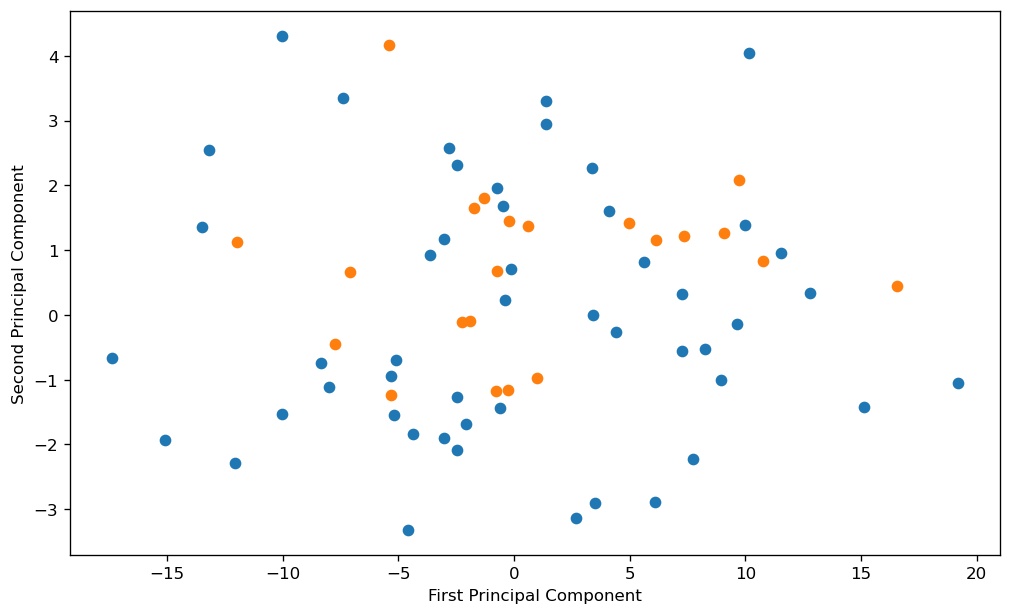

In [26]:
plt.figure(dpi=120)
plt.scatter(Xtrain[:,0],Xtrain[:,1])
plt.scatter(Xtest[:,0],Xtest[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

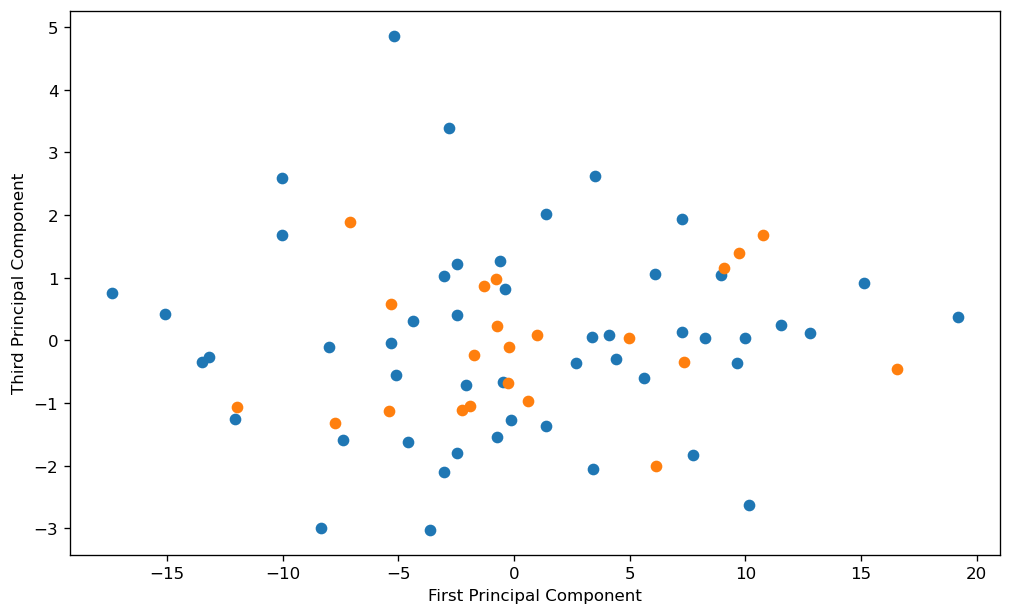

In [24]:
plt.figure(dpi=120)
plt.scatter(Xtrain[:,0],Xtrain[:,2])
plt.scatter(Xtest[:,0],Xtest[:,2])
plt.xlabel('First Principal Component')
plt.ylabel('Third Principal Component')
plt.show()

# Auto-encoders

In [33]:
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

# Define the final reduced dimensions
# usually Vanilla auto-encoders will work, i.e., just three layers
latent_dim = 5 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = Sequential([
          Flatten(),
        ])
        self.encoder.add(Dense(latent_dim, activation='relu'))
        
        
        
        self.decoder = Sequential([])
        # keep the output dimension of the decoder the same as the input of encoder
        self.decoder.add(Dense(2048, activation='sigmoid'))

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [40]:
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.00001,), loss='MSE')

autoencoder.fit(scaled_Xtrain, scaled_Xtrain,
                epochs=2000,
                shuffle=True,
                validation_data=(scaled_Xtest, scaled_Xtest))

Epoch 1/2000
2/2 [==============================] - 0s 115ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 2/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 3/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 4/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 5/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 6/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 7/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 8/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 9/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 10/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 11

2/2 [==============================] - 0s 40ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 84/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 85/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 86/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 87/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 88/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 89/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 90/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 91/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 92/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 93/2000


2/2 [==============================] - 0s 38ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 165/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 166/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 167/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 168/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 169/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 170/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 171/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0181 - val_loss: 0.0211
Epoch 172/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 173/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 36ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 246/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 247/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 248/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 249/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 250/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 251/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 252/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 253/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 254/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 34ms/step - loss: 0.0187 - val_loss: 0.0211
Epoch 327/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 328/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 329/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 330/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 331/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 332/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 333/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 334/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 335/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 38ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 408/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0187 - val_loss: 0.0211
Epoch 409/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 410/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0187 - val_loss: 0.0211
Epoch 411/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 412/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 413/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 414/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 415/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 416/2000
2/2 [==============================] - 0s 45ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 46ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 489/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 490/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 491/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 492/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 493/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 494/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 495/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 496/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 497/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 43ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 570/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 571/2000
2/2 [==============================] - 0s 48ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 572/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 573/2000
2/2 [==============================] - 0s 51ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 574/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 575/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 576/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 577/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 578/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 40ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 651/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0181 - val_loss: 0.0211
Epoch 652/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 653/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0181 - val_loss: 0.0211
Epoch 654/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 655/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 656/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0181 - val_loss: 0.0211
Epoch 657/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 658/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0181 - val_loss: 0.0211
Epoch 659/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 38ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 732/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 733/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 734/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 735/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 736/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 737/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 738/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 739/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 740/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 36ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 813/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 814/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 815/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 816/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 817/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 818/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 819/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 820/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0187 - val_loss: 0.0211
Epoch 821/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 39ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 894/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 895/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 896/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 897/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 898/2000
2/2 [==============================] - 0s 32ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 899/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 900/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 901/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 902/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 33ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 975/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 976/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 977/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 978/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 979/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 980/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 981/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 982/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 983/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch

2/2 [==============================] - 0s 39ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1055/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1056/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1057/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1058/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1059/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1060/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1061/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1062/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1063/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0184 - val_loss: 0.0

2/2 [==============================] - 0s 35ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1135/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1136/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1137/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1138/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0187 - val_loss: 0.0211
Epoch 1139/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1140/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1141/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1142/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1143/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0183 - val_loss: 0.0

2/2 [==============================] - 0s 36ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1215/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1216/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1217/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1218/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1219/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1220/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1221/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1222/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1223/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0186 - val_loss: 0.0

2/2 [==============================] - 0s 42ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1295/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1296/2000
2/2 [==============================] - 0s 45ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1297/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1298/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1299/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0181 - val_loss: 0.0211
Epoch 1300/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1301/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1302/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0187 - val_loss: 0.0211
Epoch 1303/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0184 - val_loss: 0.0

2/2 [==============================] - 0s 42ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1375/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1376/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1377/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1378/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1379/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1380/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1381/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1382/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1383/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0182 - val_loss: 0.0

2/2 [==============================] - 0s 46ms/step - loss: 0.0181 - val_loss: 0.0211
Epoch 1455/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1456/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1457/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1458/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0181 - val_loss: 0.0211
Epoch 1459/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1460/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1461/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1462/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1463/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0182 - val_loss: 0.0

2/2 [==============================] - 0s 44ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1535/2000
2/2 [==============================] - 0s 45ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1536/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1537/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1538/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1539/2000
2/2 [==============================] - 0s 46ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1540/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1541/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1542/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1543/2000
2/2 [==============================] - 0s 44ms/step - loss: 0.0185 - val_loss: 0.0

2/2 [==============================] - 0s 39ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1615/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1616/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1617/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0187 - val_loss: 0.0211
Epoch 1618/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1619/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1620/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1621/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1622/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1623/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0184 - val_loss: 0.0

2/2 [==============================] - 0s 38ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1695/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1696/2000
2/2 [==============================] - 0s 47ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1697/2000
2/2 [==============================] - 0s 75ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1698/2000
2/2 [==============================] - 0s 42ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1699/2000
2/2 [==============================] - 0s 43ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1700/2000
2/2 [==============================] - 0s 40ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1701/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1702/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1703/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0182 - val_loss: 0.0

2/2 [==============================] - 0s 41ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1775/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1776/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1777/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1778/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1779/2000
2/2 [==============================] - 0s 38ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1780/2000
2/2 [==============================] - 0s 39ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1781/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1782/2000
2/2 [==============================] - 0s 41ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1783/2000
2/2 [==============================] - 0s 37ms/step - loss: 0.0185 - val_loss: 0.0

2/2 [==============================] - 0s 32ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1855/2000
2/2 [==============================] - 0s 35ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1856/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0187 - val_loss: 0.0211
Epoch 1857/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1858/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1859/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1860/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0182 - val_loss: 0.0211
Epoch 1861/2000
2/2 [==============================] - 0s 36ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1862/2000
2/2 [==============================] - 0s 34ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1863/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0182 - val_loss: 0.0

2/2 [==============================] - 0s 33ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1935/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1936/2000
2/2 [==============================] - 0s 30ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1937/2000
2/2 [==============================] - 0s 31ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1938/2000
2/2 [==============================] - 0s 31ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1939/2000
2/2 [==============================] - 0s 31ms/step - loss: 0.0183 - val_loss: 0.0211
Epoch 1940/2000
2/2 [==============================] - 0s 30ms/step - loss: 0.0186 - val_loss: 0.0211
Epoch 1941/2000
2/2 [==============================] - 0s 31ms/step - loss: 0.0184 - val_loss: 0.0211
Epoch 1942/2000
2/2 [==============================] - 0s 33ms/step - loss: 0.0185 - val_loss: 0.0211
Epoch 1943/2000
2/2 [==============================] - 0s 30ms/step - loss: 0.0185 - val_loss: 0.0

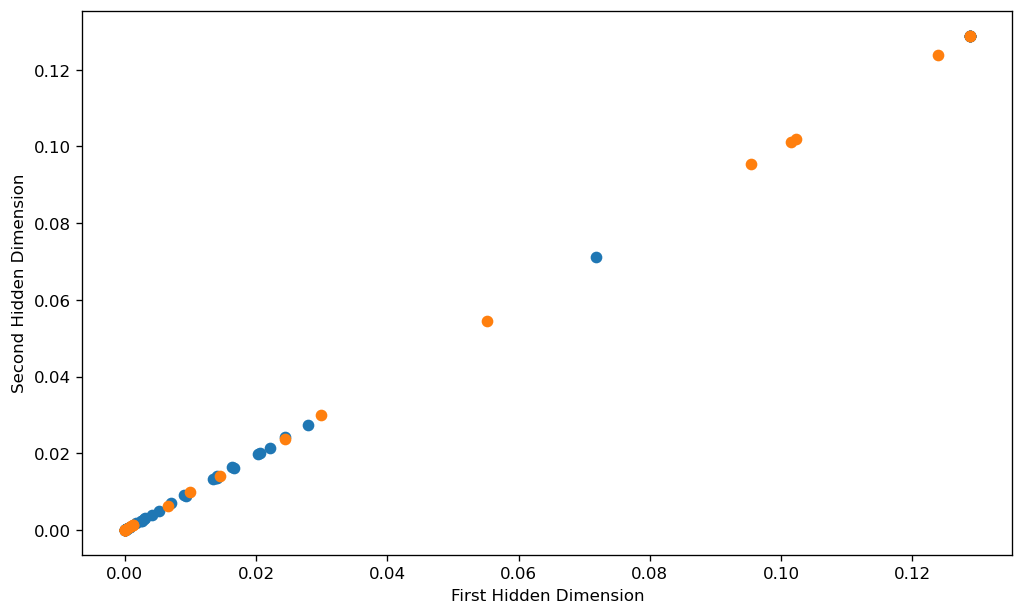

In [44]:
plt.figure(dpi=120)
plt.scatter(autoencoder.predict(scaled_Xtrain)[:,0],autoencoder.predict(scaled_Xtrain)[:,1])
plt.scatter(autoencoder.predict(scaled_Xtest)[:,0],autoencoder.predict(scaled_Xtest)[:,1])
plt.xlabel('First Hidden Dimension')
plt.ylabel('Second Hidden Dimension')
plt.show()

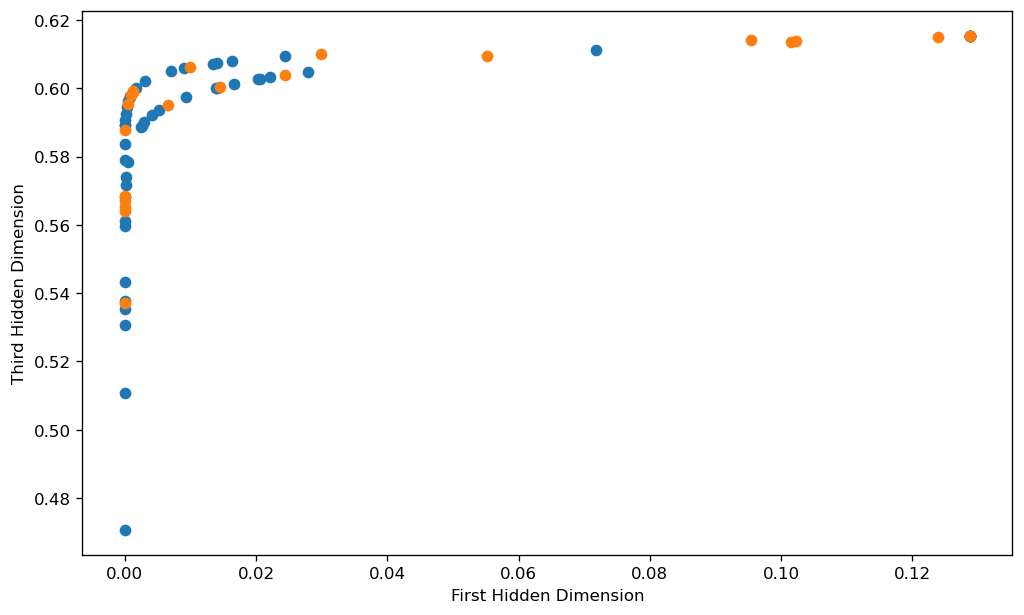

In [43]:
plt.figure(dpi=120)
plt.scatter(autoencoder.predict(scaled_Xtrain)[:,0],autoencoder.predict(scaled_Xtrain)[:,2])
plt.scatter(autoencoder.predict(scaled_Xtest)[:,0],autoencoder.predict(scaled_Xtest)[:,2])
plt.xlabel('First Hidden Dimension')
plt.ylabel('Third Hidden Dimension')
plt.show()